# Soil Fertility Prediction using Logistic Regression on Synthetic Data

This notebook demonstrates the process of building and evaluating a Logistic Regression model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe). Unlike the original notebook, this one uses the synthetic dataset generated to match the statistical properties of the original data.

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Synthetic Dataset

In [2]:
# Load the synthetic dataset
data_path = '../Datasets/synthetic_dataset.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (1005, 6)


,N,P,K,EC,Fe,Output
0,104,8.8,528,0.5,0.9,1
1,274,5.5,413,0.5,2.7,1
2,307,10.8,488,0.3,1.0,1
3,247,13.2,494,0.5,5.6,1
4,251,8.4,417,0.6,3.8,0
5,261,16.9,451,0.4,5.8,1
6,331,11.6,466,0.5,3.1,1
7,280,11.7,524,0.5,6.3,1
8,216,10.4,539,0.3,3.5,0
9,153,8.1,662,0.6,3.0,0


In [3]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       1005 non-null   int64  
 1   P       1005 non-null   float64
 2   K       1005 non-null   int64  
 3   EC      1005 non-null   float64
 4   Fe      1005 non-null   float64
 5   Output  1005 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 47.2 KB


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
N         0
P         0
K         0
EC        0
Fe        0
Output    0
dtype: int64


In [5]:
# Statistical summary of the dataset
data.describe()

,N,P,K,EC,Fe,Output
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,248.254726,13.816219,500.906468,0.533035,4.053134,0.597015
std,74.041100,19.923868,120.498711,0.135829,2.502935,0.583463
min,6.000000,2.900000,116.000000,0.200000,0.200000,0.000000
25%,201.000000,6.800000,415.000000,0.400000,2.200000,0.000000
50%,256.000000,8.100000,486.000000,0.500000,3.800000,1.000000
75%,305.000000,10.300000,582.000000,0.600000,5.700000,1.000000
max,383.000000,122.800000,887.000000,0.900000,17.500000,2.000000


Class distribution:
Output
1    500
0    455
2     50
Name: count, dtype: int64


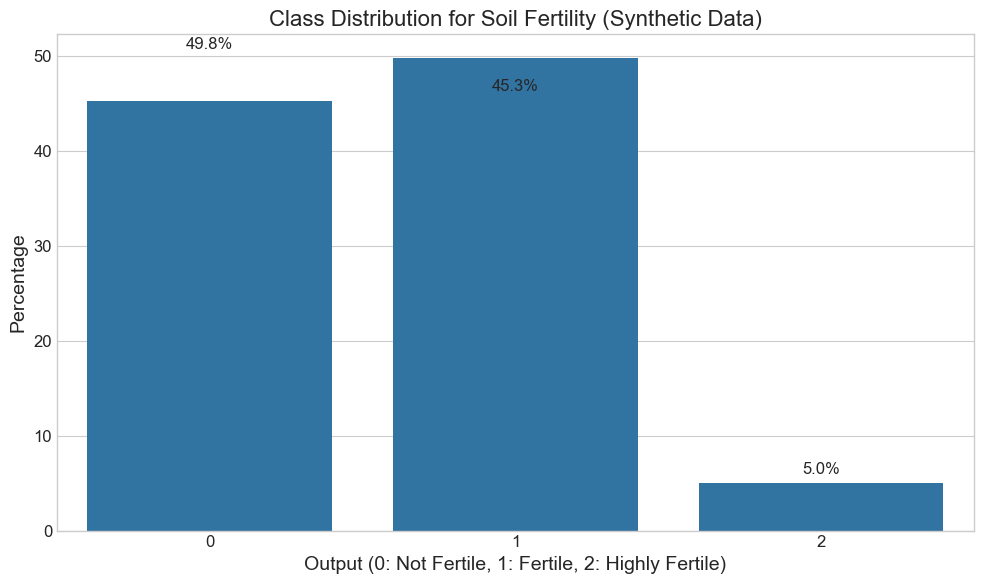

In [6]:
# Check class distribution
class_counts = data['Output'].value_counts()
print("Class distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_percentages = data['Output'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution for Soil Fertility (Synthetic Data)', fontsize=16)
plt.xlabel('Output (0: Not Fertile, 1: Fertile, 2: Highly Fertile)', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Add percentage labels on top of bars
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

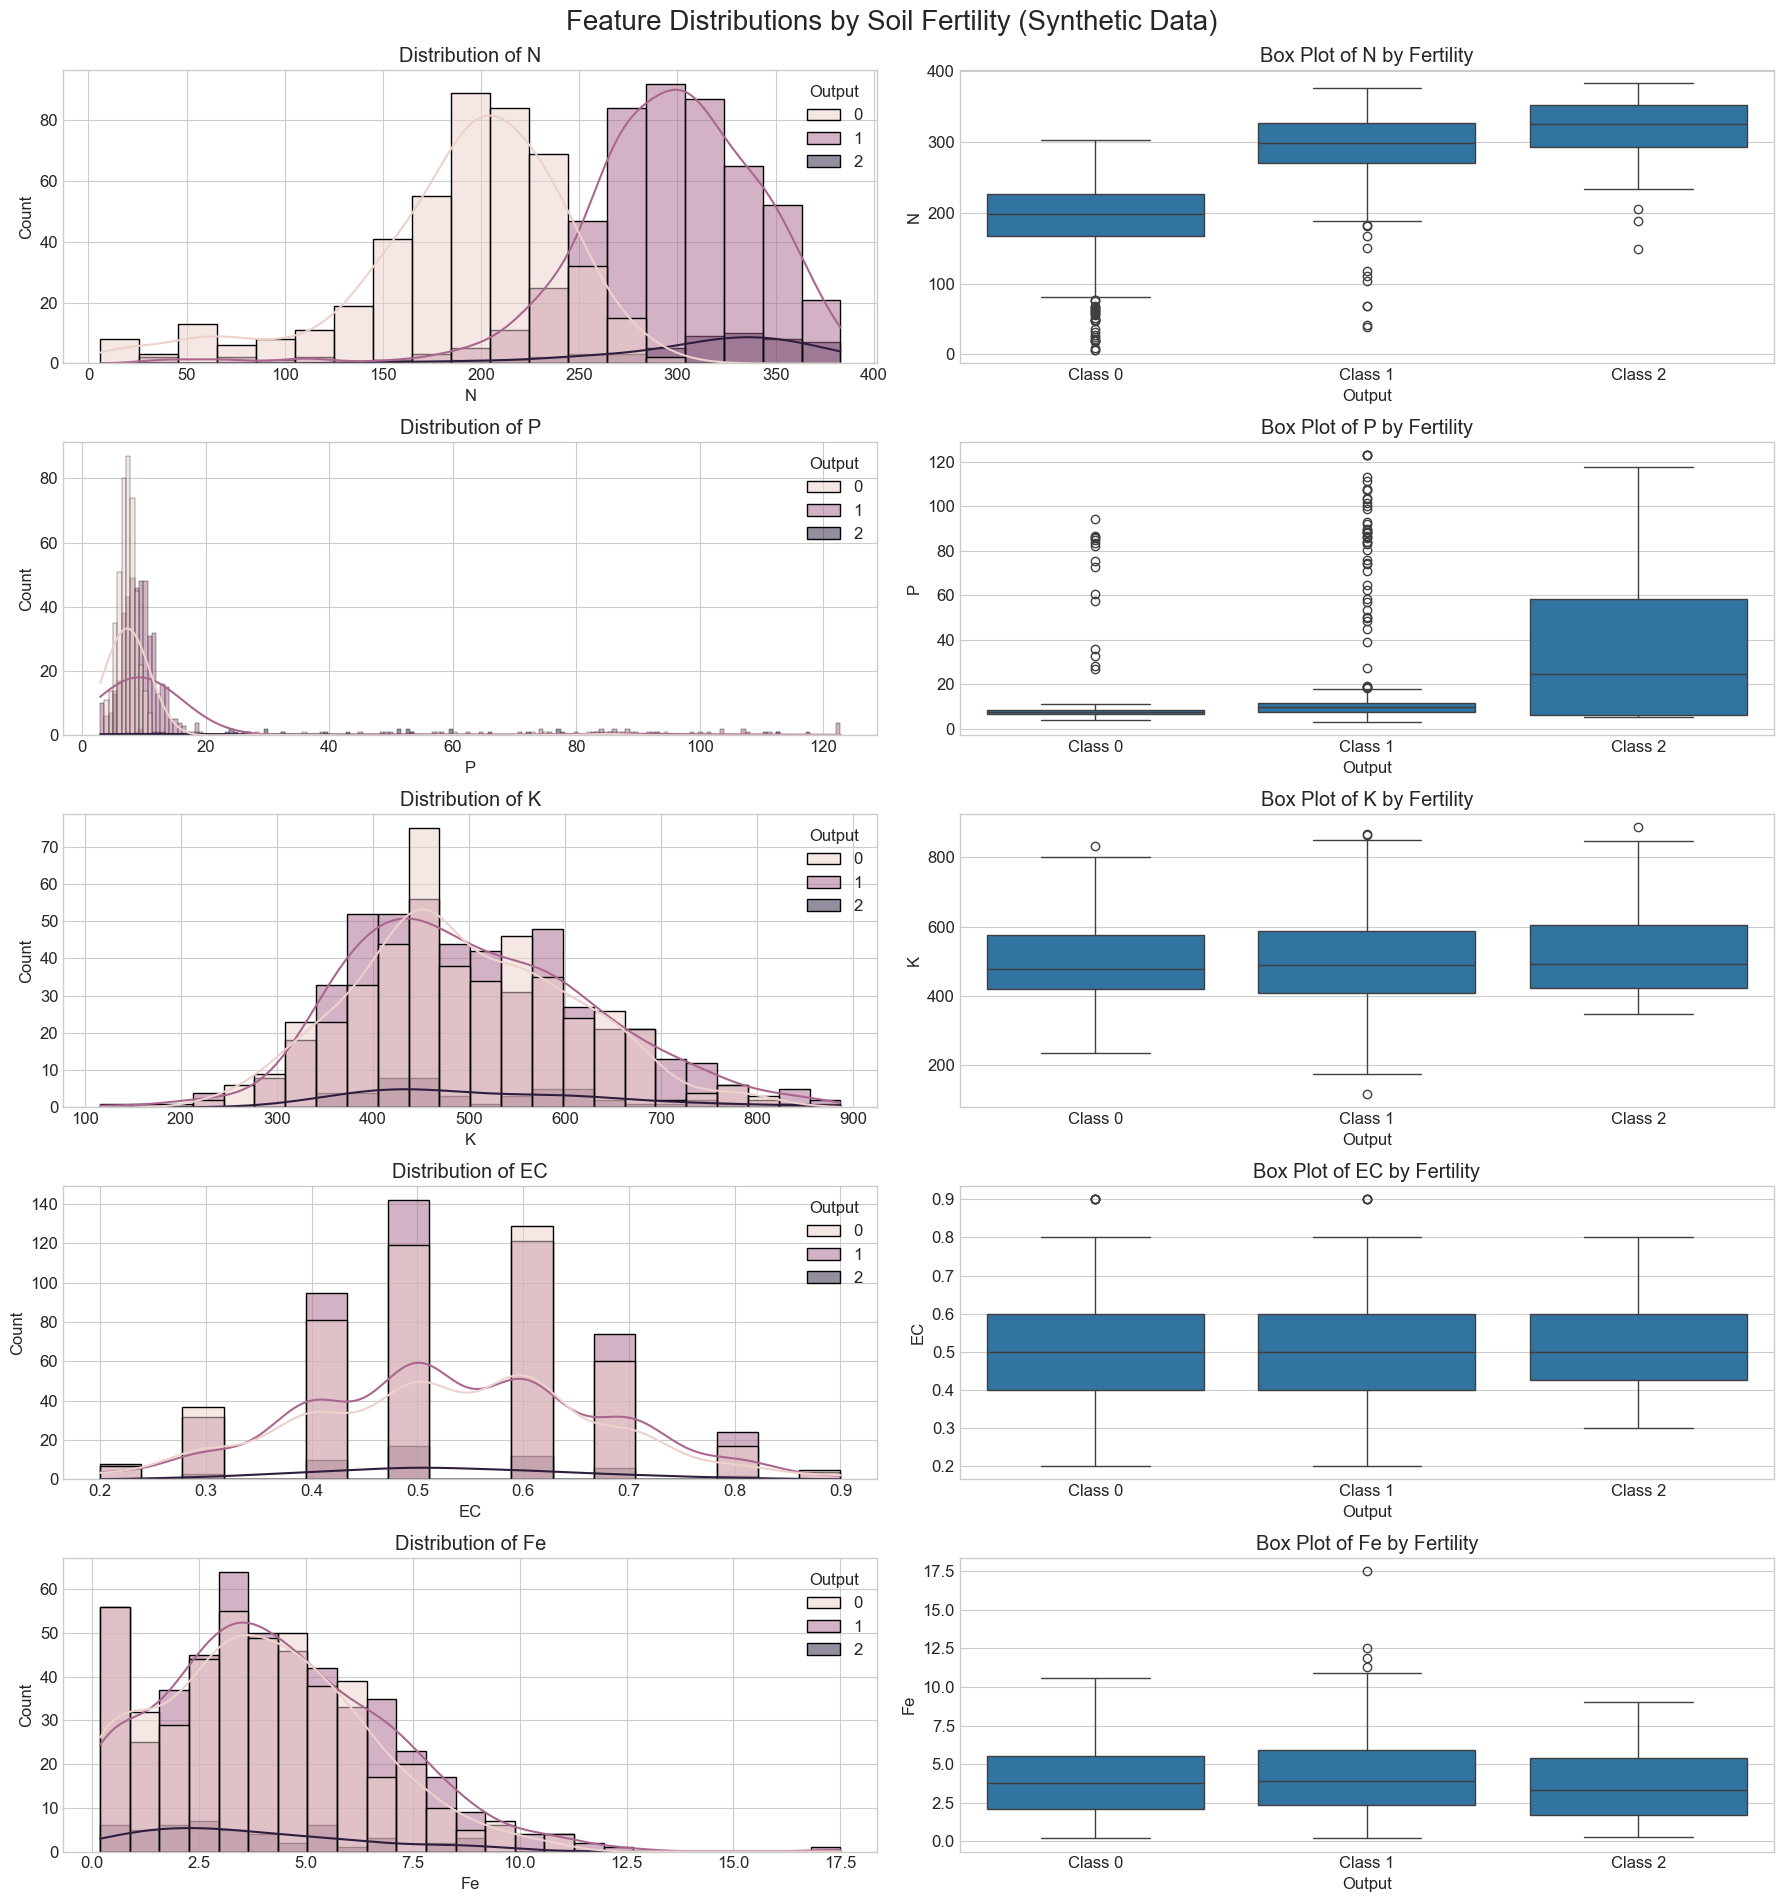

In [7]:
# Visualize the distribution of features
features = data.columns[:-1]  # All columns except the target 'Output'

fig, axes = plt.subplots(len(features), 2, figsize=(18, 20))
fig.suptitle('Feature Distributions by Soil Fertility (Synthetic Data)', fontsize=20, y=0.95)

for i, feature in enumerate(features):
    # Histogram
    sns.histplot(data=data, x=feature, hue='Output', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(data=data, x='Output', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature} by Fertility')
    
    # Set fixed tick positions
    axes[i, 1].set_xticks(range(len(data['Output'].unique())))
    axes[i, 1].set_xticklabels([f'Class {i}' for i in sorted(data['Output'].unique())])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

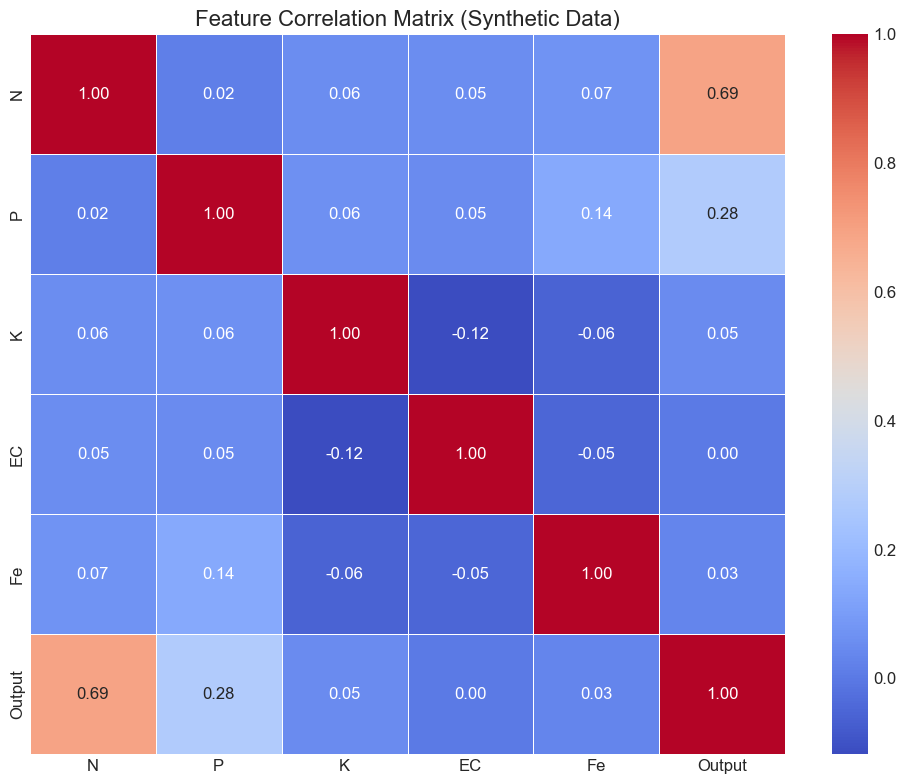

In [8]:
# Correlation matrix and heatmap
correlation = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix (Synthetic Data)', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 2000x1600 with 0 Axes>

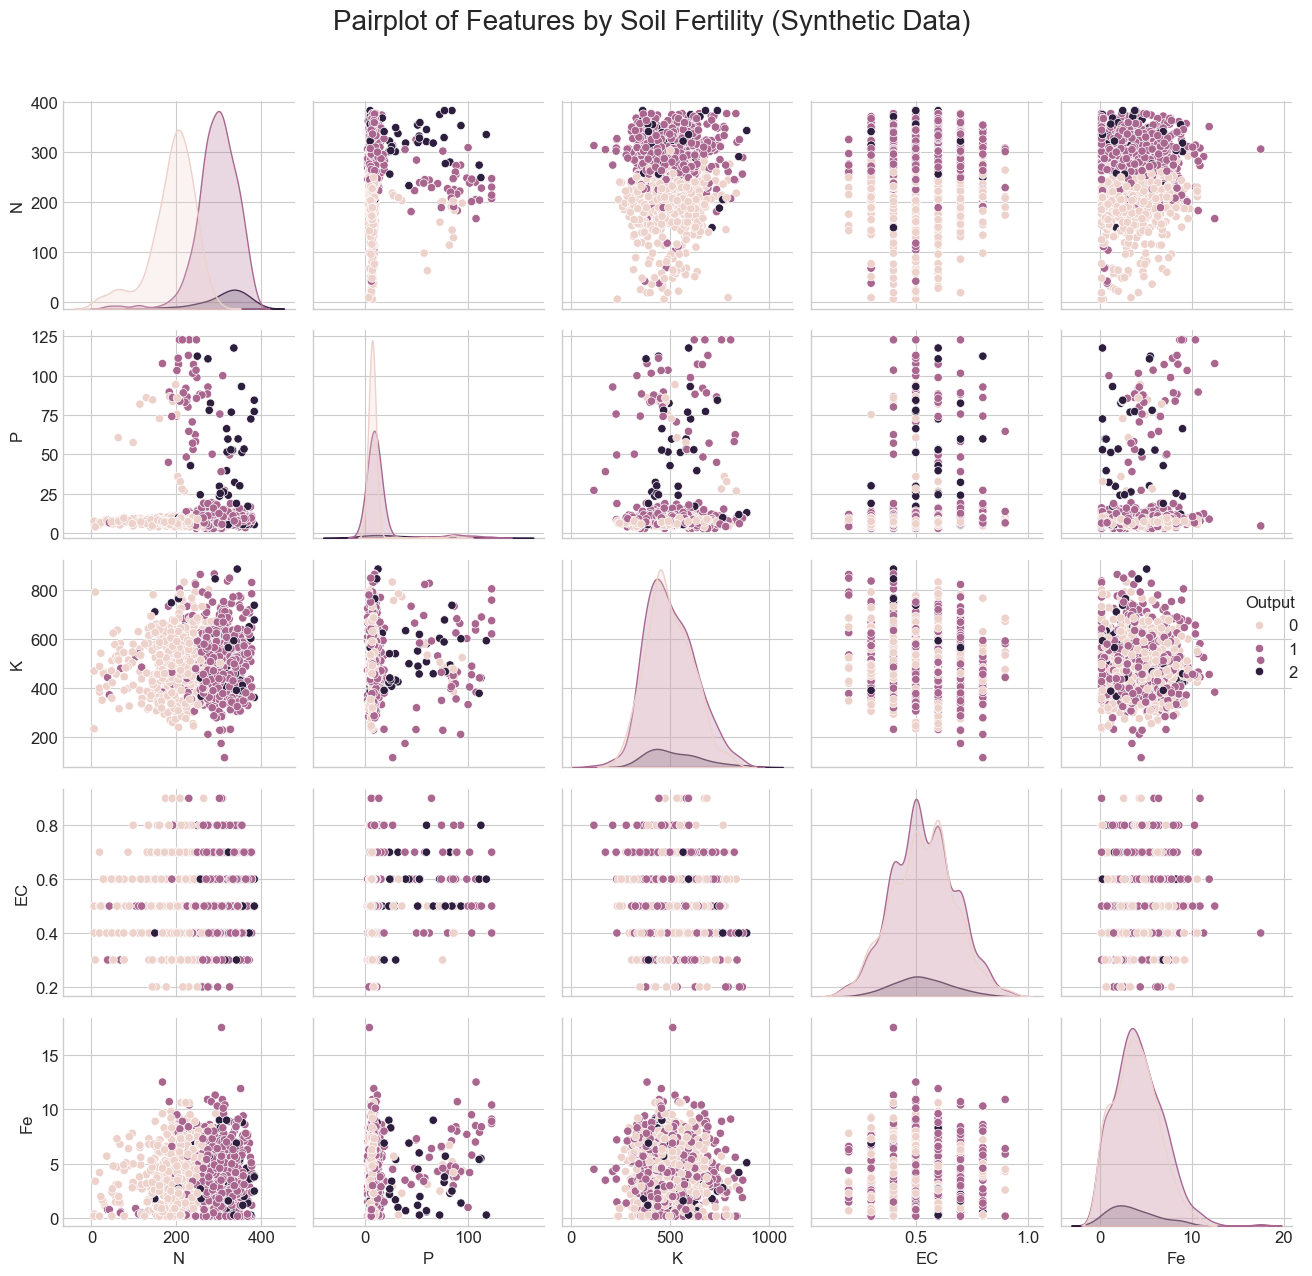

In [9]:
# Pairplot to visualize relationships between features
plt.figure(figsize=(20, 16))
sns.pairplot(data, hue='Output', diag_kind='kde')
plt.suptitle('Pairplot of Features by Soil Fertility (Synthetic Data)', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [10]:
# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (804, 5)
Testing set shape: (201, 5)

Class distribution in training set:
Output
1    49.751244
0    45.273632
2     4.975124
Name: proportion, dtype: float64

Class distribution in testing set:
Output
1    49.751244
0    45.273632
2     4.975124
Name: proportion, dtype: float64


## 5. Model Training with Hyperparameter Tuning

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

# Define the hyperparameter search space
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Define valid solver-penalty combinations
compatible_params = [
    {"classifier__penalty": ["l2"], "classifier__solver": ["lbfgs", "newton-cg", "sag", "saga"], "classifier__C": param_grid["classifier__C"]},
    {"classifier__penalty": ["l1"], "classifier__solver": ["liblinear", "saga"], "classifier__C": param_grid["classifier__C"]},
    {"classifier__penalty": ["elasticnet"], "classifier__solver": ["saga"], "classifier__C": param_grid["classifier__C"], "classifier__l1_ratio": [0.5, 1]},
    {"classifier__penalty": [None], "classifier__solver": ["newton-cg", "lbfgs", "sag", "saga"]}  # No C for None penalty
]

# Run grid search
print("Performing grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, compatible_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 52 candidates, totalling 260 fits

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score: 0.8806


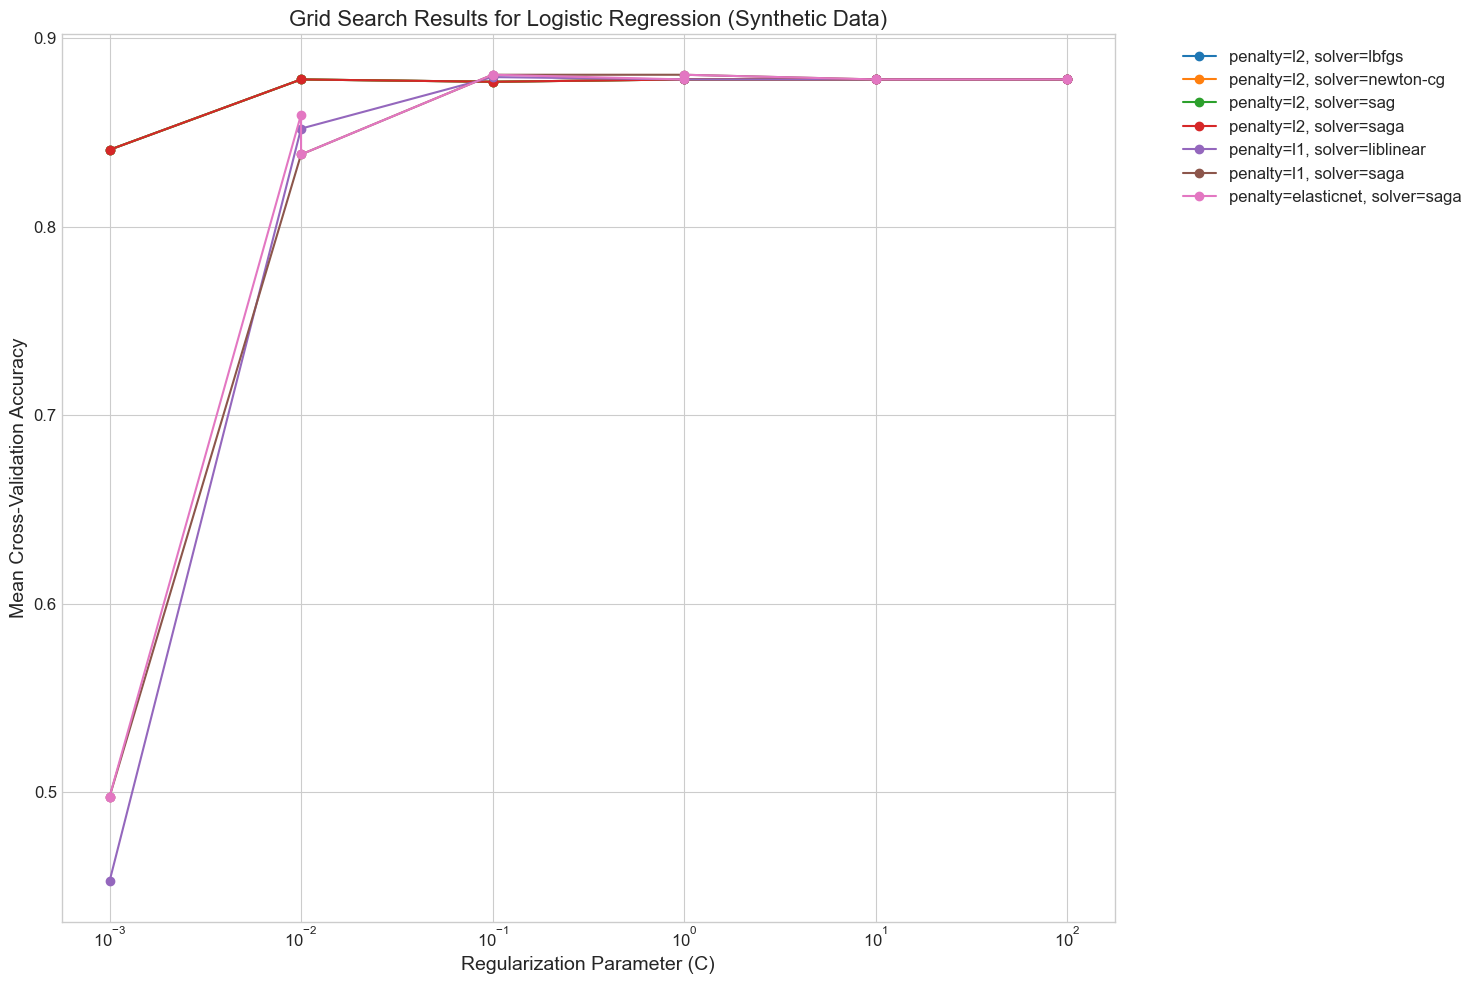

In [12]:
# Plot Grid Search Results
cv_results = grid_search.cv_results_
params = cv_results['params']
mean_scores = cv_results['mean_test_score']

# Group by penalty and solver
param_groups = {}
for i, param in enumerate(params):
    key = f"{param['classifier__penalty']}_{param['classifier__solver']}"
    if key not in param_groups:
        param_groups[key] = {'C': [], 'score': []}

    # Only append C if it exists in param
    if 'classifier__C' in param:
        param_groups[key]['C'].append(param['classifier__C'])
    else:
        param_groups[key]['C'].append(None)  # Placeholder for missing values
    
    param_groups[key]['score'].append(mean_scores[i])

# Plot
plt.figure(figsize=(15, 10))
for key, values in param_groups.items():
    penalty, solver = key.split('_')
    if len(values['C']) > 0 and None not in values['C']:  # Only plot if valid C values exist
        plt.plot(values['C'], values['score'], 'o-', label=f"penalty={penalty}, solver={solver}")

plt.xscale('log')
plt.xlabel('Regularization Parameter (C)', fontsize=14)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=14)
plt.title('Grid Search Results for Logistic Regression (Synthetic Data)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [13]:
# Make predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Training accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print(f"Training accuracy: {train_accuracy:.4f}")

# Classification report (handling undefined metrics)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Handles cases where precision is undefined

# Alternative: Handle imbalanced classes during training
best_model_balanced = LogisticRegression(random_state=42, max_iter=3000, class_weight='balanced')
best_model_balanced.fit(X_train, y_train)

# Make predictions with the balanced model
y_pred_balanced = best_model_balanced.predict(X_test)

# Evaluate balanced model performance
balanced_accuracy = accuracy_score(y_test, y_pred_balanced)
print(f"Balanced model test accuracy: {balanced_accuracy:.4f}")
print("\nBalanced Classification Report:")
print(classification_report(y_test, y_pred_balanced, zero_division=1))

Test accuracy: 0.8856
Training accuracy: 0.8806

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        91
           1       0.84      0.96      0.90       100
           2       1.00      0.00      0.00        10

    accuracy                           0.89       201
   macro avg       0.93      0.62      0.61       201
weighted avg       0.90      0.89      0.86       201

Balanced model test accuracy: 0.7761

Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        91
           1       0.90      0.66      0.76       100
           2       0.15      0.60      0.24        10

    accuracy                           0.78       201
   macro avg       0.67      0.73      0.65       201
weighted avg       0.88      0.78      0.81       201



d:\GitHub_Repos\SDP_Agri_Swastha\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


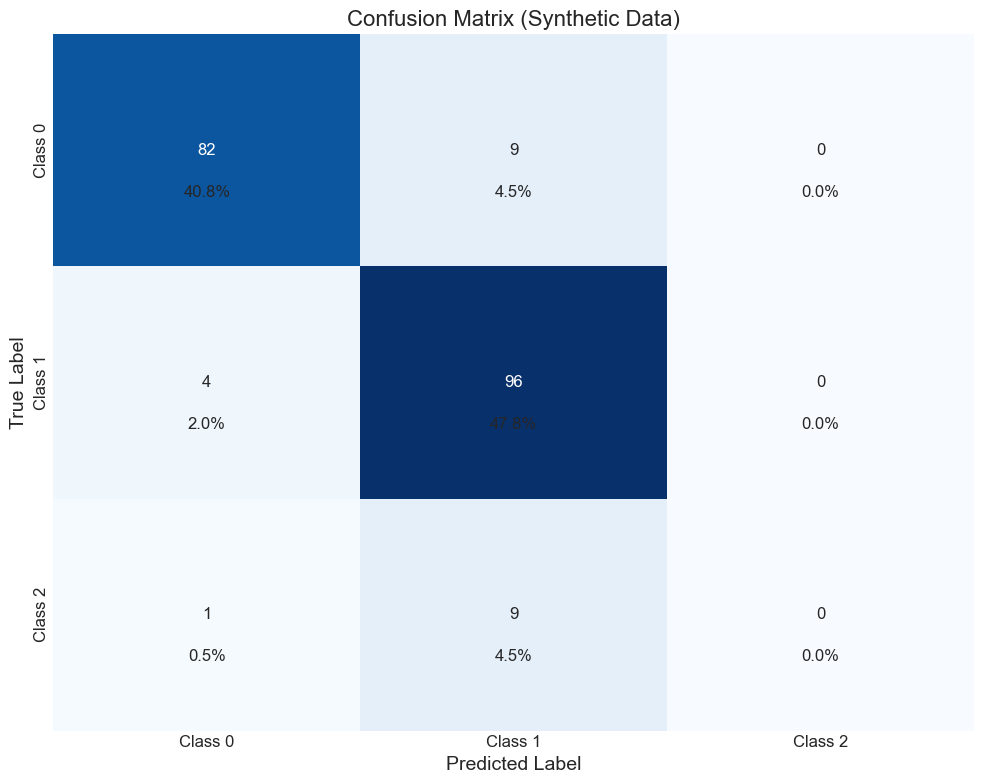

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())],
    yticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())]
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix (Synthetic Data)', fontsize=16)

# Add text annotations with percentages
total = np.sum(conf_matrix)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix[i, j] / total * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

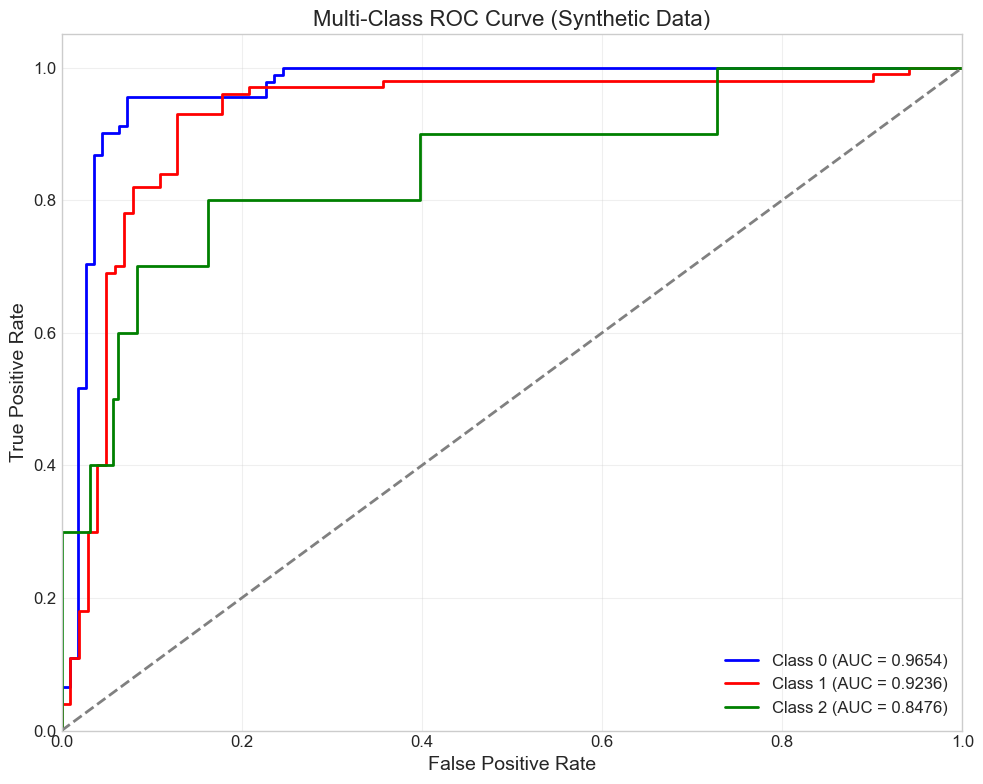

In [15]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Ensure y_test is binarized for multi-class classification
y_test_bin = label_binarize(y_test, classes=classes)

# Make sure y_prob is properly generated
y_prob = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-Class ROC Curve (Synthetic Data)", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

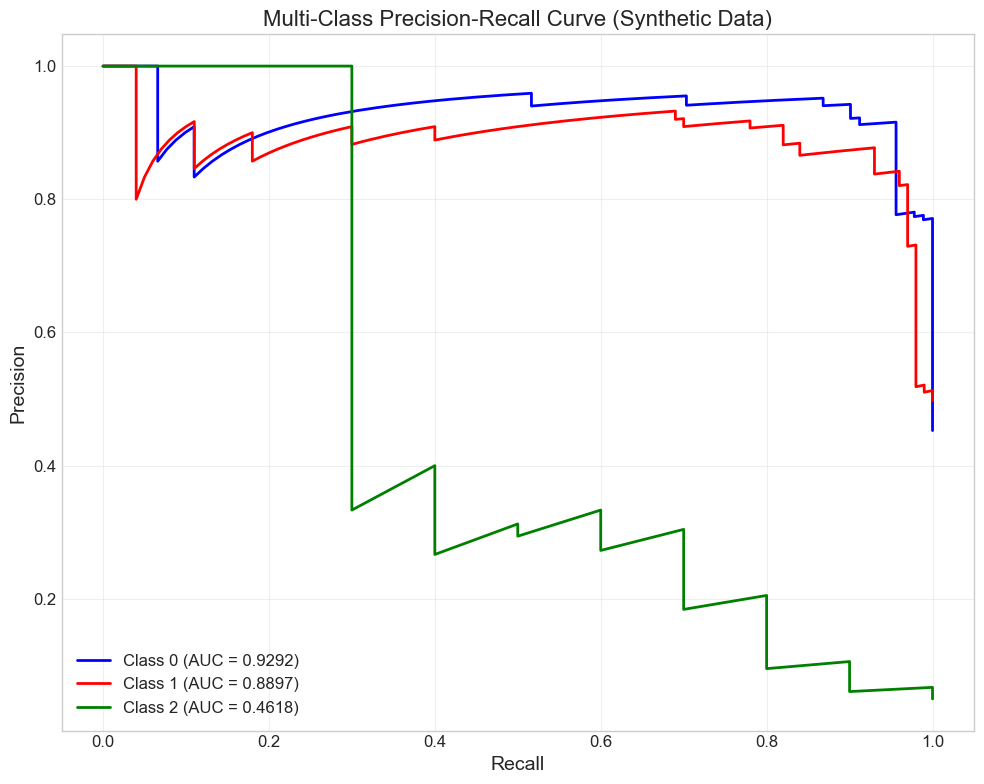

In [16]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Binarize the labels for multi-class precision-recall curves
y_test_bin = label_binarize(y_test, classes=classes)

# Ensure y_prob is in the correct format
y_prob = best_model.predict_proba(X_test)

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

    plt.plot(recall[i], precision[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {pr_auc[i]:.4f})")

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multi-Class Precision-Recall Curve (Synthetic Data)", fontsize=16)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Feature importance
# For logistic regression, we can use the coefficients
if hasattr(best_model, 'coef_'):
    coefficients = best_model.named_steps['classifier'].coef_
    feature_importance = pd.DataFrame()
    
    for i, cls in enumerate(classes):
        # Skip if there's only one class in one-vs-rest
        if i >= len(coefficients):
            continue
            
        df = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': coefficients[i],
            'Absolute Importance': np.abs(coefficients[i]),
            'Class': f'Class {cls}'
        })
        feature_importance = pd.concat([feature_importance, df])

    # Sort by absolute importance
    feature_importance_summary = feature_importance.groupby('Feature')['Absolute Importance'].mean().reset_index()
    feature_importance_summary = feature_importance_summary.sort_values(by='Absolute Importance', ascending=False)
    
    print("Feature Importance Summary (Average Absolute Importance):")
    print(feature_importance_summary)

    # Plot feature importance
    plt.figure(figsize=(12, 6))

    # Absolute importance
    plt.subplot(1, 2, 1)
    sns.barplot(x='Absolute Importance', y='Feature', data=feature_importance_summary)
    plt.title('Feature Importance (Absolute)', fontsize=14)
    plt.tight_layout()

    # Class-specific importance
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Coefficient', y='Feature', hue='Class', data=feature_importance)
    plt.title('Feature Importance by Class (Directional)', fontsize=14)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.legend(title='Class')

    plt.tight_layout()
    plt.show()

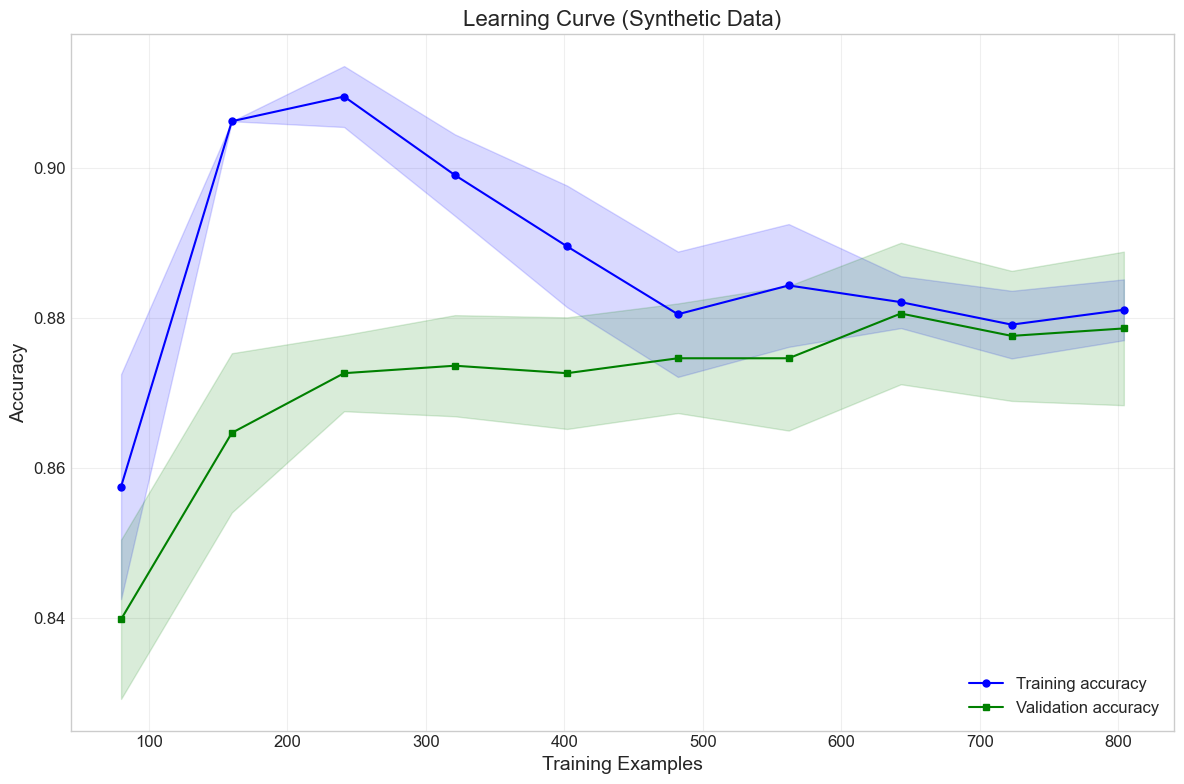

In [18]:
# Learning curve to assess overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve (Synthetic Data)', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Save the Trained Model

In [19]:
# Define the directory for saving models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'lr.pkl')
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Model saved to trained_models\lr.pkl


## 8. Model Application - Prediction Function

In [20]:
def predict_soil_fertility(model, n, p, k, ec, fe):
    """
    Predict soil fertility using the trained model.
    
    Parameters:
    - model: Trained Logistic Regression model
    - n: Nitrogen level
    - p: Phosphorus level
    - k: Potassium level
    - ec: Electrical Conductivity
    - fe: Iron level
    
    Returns:
    - prediction: Fertility class (0, 1, or 2)
    - probabilities: Probability of each class
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'EC': [ec],
        'Fe': [fe]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    
    return prediction, probabilities

In [21]:
# Example usage - test with some sample data
# Sample 1 (expected to be not fertile)
sample1 = {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
# Sample 2 (expected to be fertile)
sample2 = {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
# Sample 3 (expected to be highly fertile)
sample3 = {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}

def predict_soil_fertility_from_dict(model, sample_data):
    """Predict soil fertility using the trained model."""
    # Convert dict to DataFrame
    sample_df = pd.DataFrame([sample_data])
    prediction = model.predict(sample_df)[0]
    probabilities = model.predict_proba(sample_df)[0]
    return prediction, probabilities

# Make predictions
pred1, prob1 = predict_soil_fertility_from_dict(best_model, sample1)
pred2, prob2 = predict_soil_fertility_from_dict(best_model, sample2)
pred3, prob3 = predict_soil_fertility_from_dict(best_model, sample3)

# Define class labels for interpretation
fertility_classes = {0: "Not Fertile", 1: "Fertile", 2: "Highly Fertile"}

# Print results
print("Sample 1:")
print(f"Input: {sample1}")
print(f"Prediction: {fertility_classes[pred1]} (Class {pred1})")
print(f"Probability distribution: {prob1}")

print("\nSample 2:")
print(f"Input: {sample2}")
print(f"Prediction: {fertility_classes[pred2]} (Class {pred2})")
print(f"Probability distribution: {prob2}")

print("\nSample 3:")
print(f"Input: {sample3}")
print(f"Prediction: {fertility_classes[pred3]} (Class {pred3})")
print(f"Probability distribution: {prob3}")

Sample 1:
Input: {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
Prediction: Not Fertile (Class 0)
Probability distribution: [9.87526447e-01 1.20521127e-02 4.21439833e-04]

Sample 2:
Input: {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
Prediction: Fertile (Class 1)
Probability distribution: [0.18903761 0.75426595 0.05669643]

Sample 3:
Input: {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}
Prediction: Fertile (Class 1)
Probability distribution: [0.02838485 0.88581364 0.08580151]


## 9. Comparison with Original Dataset Model

Now we'll compare the model trained on synthetic data with the model trained on the original dataset to see if there are any significant differences.

In [22]:
# Load the model trained on the original data
original_model_path = os.path.join(model_dir, 'lr.pkl')
if os.path.exists(original_model_path):
    original_model = joblib.load(original_model_path)
    
    # Compare predictions on test samples
    print("Comparing predictions between original and synthetic data models:")
    
    # Test samples
    test_samples = [sample1, sample2, sample3]
    
    for i, sample in enumerate(test_samples):
        # Predict with synthetic model
        syn_pred, syn_prob = predict_soil_fertility_from_dict(best_model, sample)
        
        # Predict with original model
        orig_pred, orig_prob = predict_soil_fertility_from_dict(original_model, sample)
        
        print(f"\nSample {i+1}:")
        print(f"Synthetic model prediction: {fertility_classes.get(syn_pred, f'Class {syn_pred}')} (confidence: {np.max(syn_prob):.4f})")
        print(f"Original model prediction: {fertility_classes.get(orig_pred, f'Class {orig_pred}')} (confidence: {np.max(orig_prob):.4f})")
else:
    print("Original model not found. Cannot compare models.")

Comparing predictions between original and synthetic data models:

Sample 1:
Synthetic model prediction: Not Fertile (confidence: 0.9875)
Original model prediction: Not Fertile (confidence: 0.9875)

Sample 2:
Synthetic model prediction: Fertile (confidence: 0.7543)
Original model prediction: Fertile (confidence: 0.7543)

Sample 3:
Synthetic model prediction: Fertile (confidence: 0.8858)
Original model prediction: Fertile (confidence: 0.8858)


## 10. Conclusions and Next Steps

### Summary
In this notebook, we have:
1. Loaded and explored the synthetic soil fertility dataset
2. Performed exploratory data analysis to understand feature distributions and relationships
3. Preprocessed the data by scaling features and splitting into training/testing sets
4. Trained a Logistic Regression model with hyperparameter tuning
5. Evaluated model performance using various metrics and visualizations
6. Saved the trained model for future use
7. Created an interactive prediction interface
8. Compared predictions with the original dataset model

### Key Insights
- The model trained on synthetic data shows performance metrics that indicate how well it can predict soil fertility
- Feature importance analysis reveals which soil parameters are most influential in determining fertility in the synthetic data
- The comparison between models trained on synthetic vs. original data helps validate the quality of the synthetic data generation process

### Next Steps
1. Expand the analysis with additional models: KNN, SVM, and Random Forest Classifier
2. Compare the performance across all models and datasets to select the best one for implementation
3. Integrate the model with IoT sensors for real-time soil parameter readings
4. Develop the .NET MAUI application interface for user-friendly access to predictions
5. Implement model monitoring to track performance over time and with new data
6. Further refine the synthetic data generation process based on model performance differences

This model serves as another step in creating a comprehensive soil fertility analysis system for the SDP_Agri_Swastha project.